#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임 워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [108]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score # 성능지표 관련 모듈
from torchinfo import summary  #모델 정보 관련모듈

import pandas as pd             # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [109]:
# 랜덤 시드 고정 , 모델의 가중치 및 절편 값 고정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [110]:
# 데이터 로딩 : CSV = > DataFrame
DATA_FILE='iris.csv'

irisDF=pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 - 회귀
- 알고리즘 : 선형관계 - 선형모델 => nn.Linear

In [111]:
# 모델 설계
# 입력층의 입력값/피쳐 : petal.length, sepal.length, sepal.width 3개
# 출력층의 출력값/타겟 : petal.width 1개
# 입력층   : 입력 피쳐3, 출력 존재하는 퍼셉트론 개수 10, AF RELU
#                        |   
#                 ㅡㅡㅡㅡ
#                |
#                V
# 은닉층   : 입력 10,    출력  존재하는 퍼셉트론 개수 5, AF REL
#                        |   
#                 ㅡㅡㅡㅡ
#                |
#                V
# 출력층   : 입력 5,    출력 타겟/라벨 개수 1           AF 
model = nn.Sequential( nn.Linear(3,10), #입력층의 입력은 피쳐가 3개니까 3
                    nn.ReLU(),
                    nn.Linear(10,5),
                    nn.ReLU(),
                    nn.Linear(5,1)) # 출력층의 출력은 타겟이 1개니까 1

In [112]:
print(model)
summary(model, input_size=(150,3))  # input_size에 몇개의 데이터를 줄지 넣는것이다.

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [150, 1]                  --
├─Linear: 1-1                            [150, 10]                 40
├─ReLU: 1-2                              [150, 10]                 --
├─Linear: 1-3                            [150, 5]                  55
├─ReLU: 1-4                              [150, 5]                  --
├─Linear: 1-5                            [150, 1]                  6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [113]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)

[0.bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)

[2.weight] Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0

[3] 최적화 인스턴스 준비

In [114]:
## 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현

[4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행 하거나 또는 학습 전 진행

In [115]:
featureDF=irisDF[irisDF.columns[:-1]]
targetDF=irisDF[['petal.width']]

print(featureDF.shape, targetDF.shape)

(150, 3) (150, 1)


In [116]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size=0.2, random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(f'[Feature] Train {X_train.shape}, TEST { X_test.shape}, VAL {X_val.shape}')
print(f'[Target] Train {y_train.shape}, TEST { y_test.shape}, VAL {y_val.shape}')

[Feature] Train (96, 3), TEST (30, 3), VAL (24, 3)
[Target] Train (96, 1), TEST (30, 1), VAL (24, 1)


[4-2] 학습진행  
    * 학습횟수 결정 ==> 에포크 설정  
    * 배치크기 결정
    * 배치개수 계산 

In [117]:
EPOCH=100                                                                      # 처음~끝까지 공부하는 횟쉬
BATCH_SIZE=12                                                                   # 1에포크에서 한번 학습할 분량
BATCH_CNT = X_train.shape[0]//BATCH_SIZE                                        # 1에포크에서 총 학습 횟수이면서 업데이트횟수

print(f'EPOCH:{EPOCH}, BATCH_SIZE:{BATCH_SIZE}, BATCH_CNT:{BATCH_CNT}')

EPOCH:100, BATCH_SIZE:12, BATCH_CNT:8


## 함수로만들기

In [118]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
# 모델 학습 함수
def testing(testDF,targetDF, kind='Val'):
    # Tensor화
    testTS = torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS=torch.FloatTensor(targetDF.values).to(DEVICE)
    with torch.no_grad():    # 가중치 및 절편 업데이트 진행 X
        #-(1)학습진행 - forward
        pre_y=model(testTS)
        #-(2)오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        
        #-(3)성능평가 - R2
        r2 = R2Score()(pre_y, targetTS)

        #-(4)학습결과 출력 및 저장
        print(f'[{kind}] LOSS: {loss}, R2 : {r2}')

    return loss, r2

In [119]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):

    loss_history=[[],[]] # [[트레인], [검증]]
    r2_history=[[],[]]   # [[트레인], [검증]]
    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss, bs_r2=0,0
        # 배치 크기 만큼 학습 진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE
            end = start + BATCH_SIZE
            #print(start, end)
            # BS크기만큼만 데이터 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(DEVICE) # 배치의 트레인 피쳐
            BSy_train= torch.FloatTensor(y_train[start:end].values).to(DEVICE)  # 배치의 트레인 정답

            #print(BSX_train.shape, BSX_train.device, BSX_train.dtype)
            #print(BSy_train.shape, BSy_train.device, BSy_train.dtype)

            #-(1)학습진행 - forward
            pre_y=model(BSX_train)
            #-(2)오차계산 - 손실함수
            loss=F.mse_loss(pre_y, BSy_train)
            bs_loss +=loss.item()   # 손실함수 추가가
            bs_r2 += R2Score()(pre_y, BSy_train).item()


            #-(3)최적화 - 가중치,절편 업데이트 backward
            adam_optim.zero_grad() #gradient를 0으로 초기화
            loss.backward() #  오차 미분, 비용 함수를 미분하여 gradient 계산
            adam_optim.step() #  가중치 업데이트 W와 b를 업데이트

        #-(4)검증 - 모댈이 제대로 만들어지는 검사용
        val_loss, val_r2 = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())
        
        # 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        #-(4)학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] \n Train LOSS: {loss_history[0][-1]} R2 : {r2_history[0][-1]}')
        print(f'-VALID LOSS: {loss_history[1][-1]} R2 : {r2_history[1][-1]}')
    return  loss_history, r2_history

In [120]:
# 모델 학습 진행
loss, r2 = training(X_train, y_train, X_val, y_val)

[Val] LOSS: 0.4191381633281708, R2 : -0.004299283027648926
[0/100] 
 Train LOSS: 0.9069786705076694 R2 : -0.5297544598579407
-VALID LOSS: 0.4191381633281708 R2 : -0.004299283027648926
[Val] LOSS: 0.49096497893333435, R2 : -0.17640399932861328
[1/100] 
 Train LOSS: 0.6465997360646725 R2 : -0.10939279198646545
-VALID LOSS: 0.49096497893333435 R2 : -0.17640399932861328
[Val] LOSS: 0.44149693846702576, R2 : -0.05787336826324463
[2/100] 
 Train LOSS: 0.6715940572321415 R2 : -0.1355888992547989
-VALID LOSS: 0.44149693846702576 R2 : -0.05787336826324463
[Val] LOSS: 0.3640381097793579, R2 : 0.12772619724273682
[3/100] 
 Train LOSS: 0.6003708094358444 R2 : -0.018216572701931
-VALID LOSS: 0.3640381097793579 R2 : 0.12772619724273682
[Val] LOSS: 0.26617205142974854, R2 : 0.36222362518310547
[4/100] 
 Train LOSS: 0.46007593162357807 R2 : 0.2417171597480774
-VALID LOSS: 0.26617205142974854 R2 : 0.36222362518310547
[Val] LOSS: 0.03169037774205208, R2 : 0.9240664839744568
[5/100] 
 Train LOSS: 0.19732

In [121]:
loss

[[0.9069786705076694,
  0.6465997360646725,
  0.6715940572321415,
  0.6003708094358444,
  0.46007593162357807,
  0.19732970278710127,
  0.07605496211908758,
  0.1008317454252392,
  0.07504434487782419,
  0.05300577008165419,
  0.04644324001856148,
  0.04479476111009717,
  0.044833490159362555,
  0.04498625104315579,
  0.04434948577545583,
  0.04325701971538365,
  0.042661872459575534,
  0.042554122395813465,
  0.042294645216315985,
  0.041758517269045115,
  0.04132198030129075,
  0.04104750556871295,
  0.04071664530783892,
  0.04036544542759657,
  0.040083488915115595,
  0.039794647600501776,
  0.03951195767149329,
  0.039265384431928396,
  0.03902175556868315,
  0.03880188474431634,
  0.038599199848249555,
  0.038413038244470954,
  0.038248631404712796,
  0.038100275909528136,
  0.037960234796628356,
  0.03752162121236324,
  0.037400985369458795,
  0.03750414028763771,
  0.03719846857711673,
  0.037370461504906416,
  0.037086402997374535,
  0.03735381213482469,
  0.03703165613114834,


In [122]:
testing(X_test, y_test)

[Val] LOSS: 0.051203664392232895, R2 : 0.9019526243209839


(tensor(0.0512), tensor(0.9020))

Text(0.5, 1.0, 'LOSS')

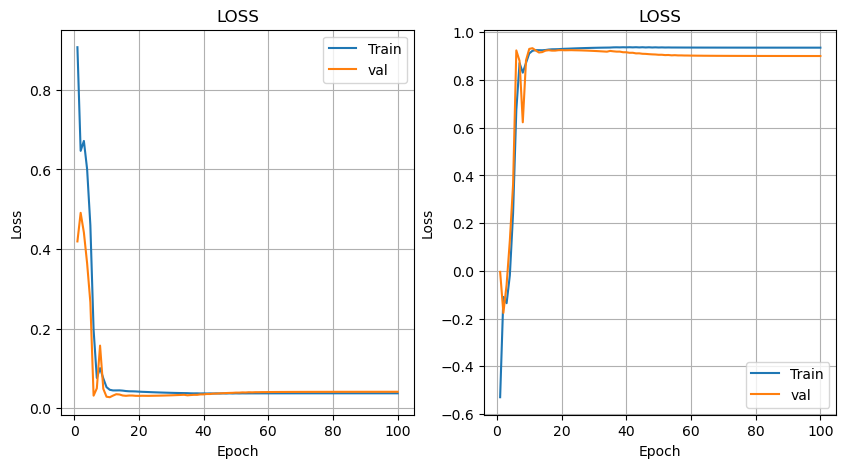

In [123]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=100
fg, axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), loss[1][:THRESHOLD], label='val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, THRESHOLD+1), r2[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), r2[1][:THRESHOLD], label='val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("LOSS")